In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import *
from matplotlib.pyplot import figure

Using TensorFlow backend.


In [2]:
df = pd.read_csv ('/data/Data/yntn/data_labeled.csv')

Text(0.5, 0, 'Label')

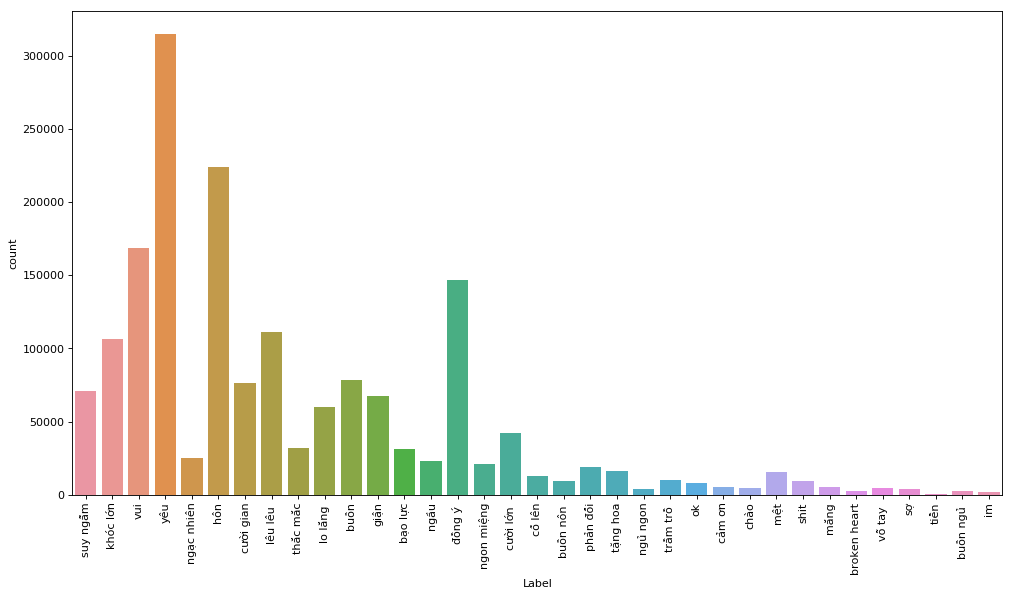

In [3]:
figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
plt.xticks(rotation=90)
sns.countplot(df.label)
plt.xlabel('Label')

In [4]:
X = df.text
Y = df.label
le = LabelEncoder()
Y = le.fit_transform(Y)

In [5]:
onehot_Y = []

for i in range(len(Y)):
    tmp = []
    tmp = [ 0 for i in range(0, 35)] # set all 0
    tmp[Y[i]] = 1 
    onehot_Y.append(tmp)

In [6]:
Y = np.array(onehot_Y)

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2, random_state = 42)

In [8]:
max_words = 88860
max_len = 30
tok = Tokenizer(num_words = max_words)
X_train = [str(s) for s in X_train]
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [9]:
pickle.dump(tok, open('tokenize.pkl','wb'))

In [10]:
word_dict = pickle.load (open("/data/Data/yntn/word_embedding_vec.pkl",'rb'))

In [11]:
w = np.random.normal(0, 1, (max_words, 300))

In [12]:
for i in range (1, len(tok.index_word)):
    if (tok.index_word[i] in word_dict):
        w[i] = word_dict[tok.index_word[i]]

In [13]:
def RNN():
    inputs = Input(name = 'inputs', shape = [max_len])
    layer = Embedding(max_words, 300, input_length = max_len, weights = [w])(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name = 'FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(35,name = 'out_layer')(layer)
    layer = Activation('softmax')(layer)
    model = Model(inputs = inputs,outputs = layer)
    return model

In [14]:
model  = RNN()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 30)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 30, 300)           26658000  
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                93440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 35)                8995      
__________

In [15]:
model.compile(loss = 'categorical_crossentropy', optimizer = RMSprop(),metrics = ['accuracy'])

In [16]:
weight_file = "model_LSTM.hdf5"
callbacks = [
    EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1),
    ModelCheckpoint(weight_file, monitor = 'val_loss', verbose = 1, save_best_only = True)
]

In [17]:
history = model.fit(sequences_matrix,Y_train,batch_size = 512, epochs = 10,
          validation_split = 0.2, callbacks = callbacks)

Train on 1109777 samples, validate on 277445 samples
Epoch 1/10
1109777/1109777 [==============================] - 145s 131us/step - loss: 2.4323 - acc: 0.2619 - val_loss: 2.3586 - val_acc: 0.2784

Epoch 00001: val_loss improved from inf to 2.35860, saving model to model_LSTM.hdf5
Epoch 2/10
1109777/1109777 [==============================] - 144s 130us/step - loss: 2.3534 - acc: 0.2828 - val_loss: 2.3345 - val_acc: 0.2851

Epoch 00002: val_loss improved from 2.35860 to 2.33449, saving model to model_LSTM.hdf5
Epoch 3/10
1109777/1109777 [==============================] - 144s 129us/step - loss: 2.3267 - acc: 0.2898 - val_loss: 2.3305 - val_acc: 0.2863

Epoch 00003: val_loss improved from 2.33449 to 2.33052, saving model to model_LSTM.hdf5
Epoch 4/10
1109777/1109777 [==============================] - 144s 130us/step - loss: 2.3070 - acc: 0.2955 - val_loss: 2.3288 - val_acc: 0.2887

Epoch 00004: val_loss improved from 2.33052 to 2.32877, saving model to model_LSTM.hdf5
Epoch 5/10
1109777/

In [18]:
X_test = [str(s) for s in X_test]
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)
accr = model.evaluate(test_sequences_matrix,Y_test)

346806/346806 [==============================] - 191s 551us/step


In [19]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 2.365
  Accuracy: 0.286
